# Ibrahim Gabr - Clarifai Summer Internship Application Technical Assessment 2017

Let's first import our libraries!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline
%pdb
%xmode Verbose

Automatic pdb calling has been turned ON
Exception reporting mode: Verbose


Let's first load the data using the pandas library

In [2]:
ops_data = pd.read_csv("ops.csv")
users_data = pd.read_csv("users.csv")

# OPS Database

In [3]:
ops_data.shape

(56142, 4)

In [4]:
ops_data.head(1)

,op_time,user_id,op_count,response
0,2016-09-29 19:04:00,c1347e11416f,1,200


In [5]:
ops_data['response'].unique()

array([200, 400, 404, 500, 402, 207])

The above response codes correspond to HTTP status codes!

200: OK
400: Bad Request
404: Not Found
500: Internal Server Error
402: Reserved for payments but is usually used when an individual has exceeded API request limits.
207: Multi-Status

Let's see a distribution of all responses!

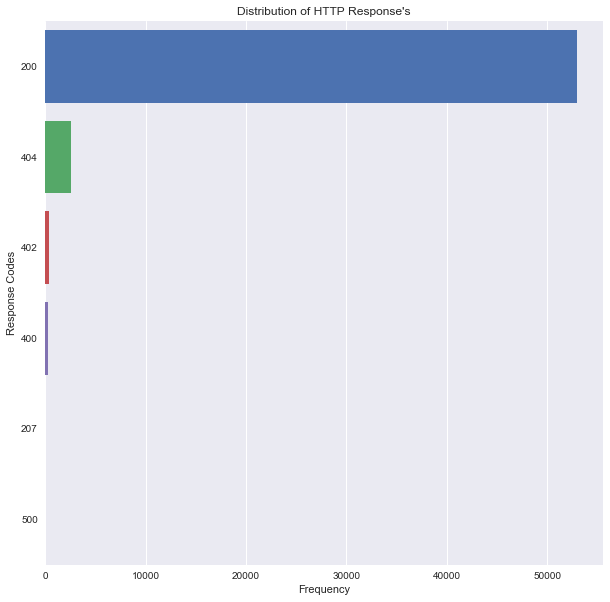

In [6]:
ops_response_hist = ops_data['response'].value_counts(sort=True)
plt.figure(figsize=(10,10))
graph=sns.countplot(y="response", saturation=1, data=ops_data, order=ops_response_hist.index)
plt.title("Distribution of HTTP Response's")
plt.xlabel("Frequency")
plt.ylabel("Response Codes")

The above is distribution is great - shows that the majority of requests are going through!

An interesting business question would be to assess at what hours of the day and what month's does our system see the most activity. Once we have this information, we can ensure that certain system maintenance is done before hand, ensure that our ad's are most visable, ensure we are at full capacity for customer support etc.

Let's go ahead and figure out when our system has the most activity

We can split up the OP_time variable into the month and the hour. Let's write a quick function for this.

In [7]:
def split_time_date(lst):
    month_list = []
    hour_list = []
    for i in lst:
        date, time = i.split(" ")
        month_number = datetime.strptime(date, "%Y-%m-%d").month
        month_list.append(month_number)
        hours, minutes, seconds = time.split(":")
        hour_list.append(hours)
    return month_list, hour_list

In [8]:
date_time_info = list(ops_data['op_time'])
month_list, hour_list = split_time_date(date_time_info)
hour_series = pd.Series(hour_list)
month_series = pd.Series(month_list)
ops_data['Hour'] = hour_series
ops_data['Month'] = month_series

In [9]:
ops_data.head(1)

,op_time,user_id,op_count,response,Hour,Month
0,2016-09-29 19:04:00,c1347e11416f,1,200,19,9


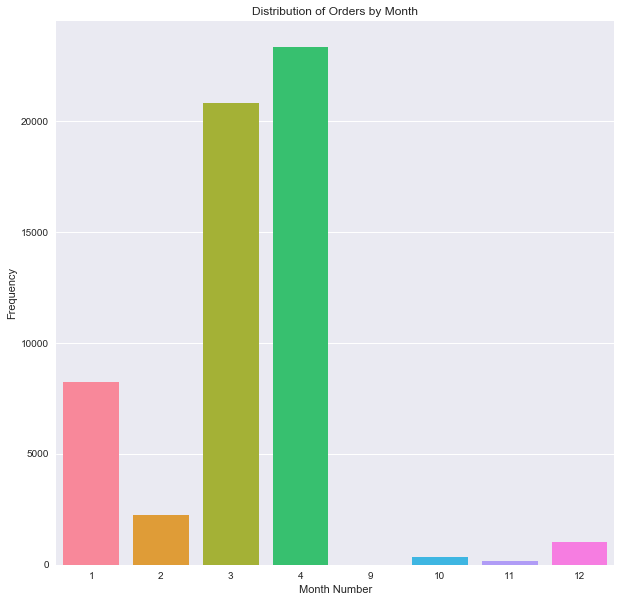

In [10]:
ops_order_month = ops_data['Month'].value_counts(sort=False)
plt.figure(figsize=(10,10))
graph=sns.countplot(x="Month", saturation=1, data=ops_data, order=ops_order_month.index)
plt.title("Distribution of Orders by Month")
plt.xlabel("Month Number")
plt.ylabel("Frequency")

From the above distribution we can see that orders seem to spike in March/April followed by January.

I was expecting December to have a much higher frequency (due to xmas), then again, I dont really know what system I am evaluating. 

Let's zoom in!

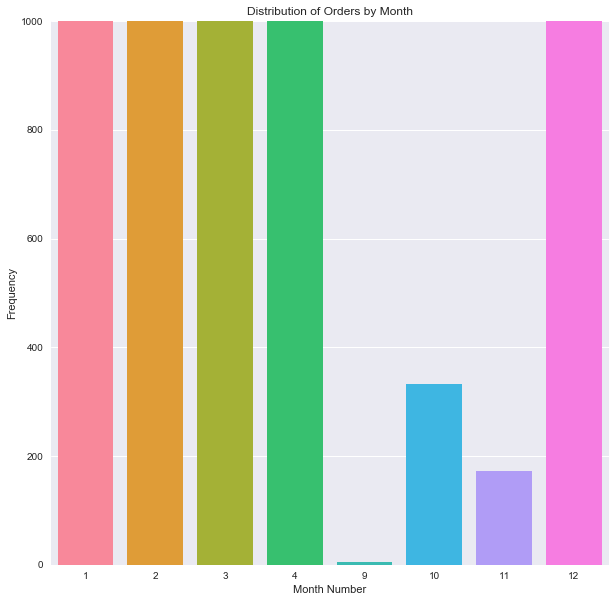

In [11]:
ops_order_month = ops_data['Month'].value_counts(sort=False)
plt.figure(figsize=(10,10))
graph=sns.countplot(x="Month", saturation=1, data=ops_data, order=ops_order_month.index)
plt.ylim((0, 1000))#limit y to 1000
plt.title("Distribution of Orders by Month")
plt.xlabel("Month Number")
plt.ylabel("Frequency")

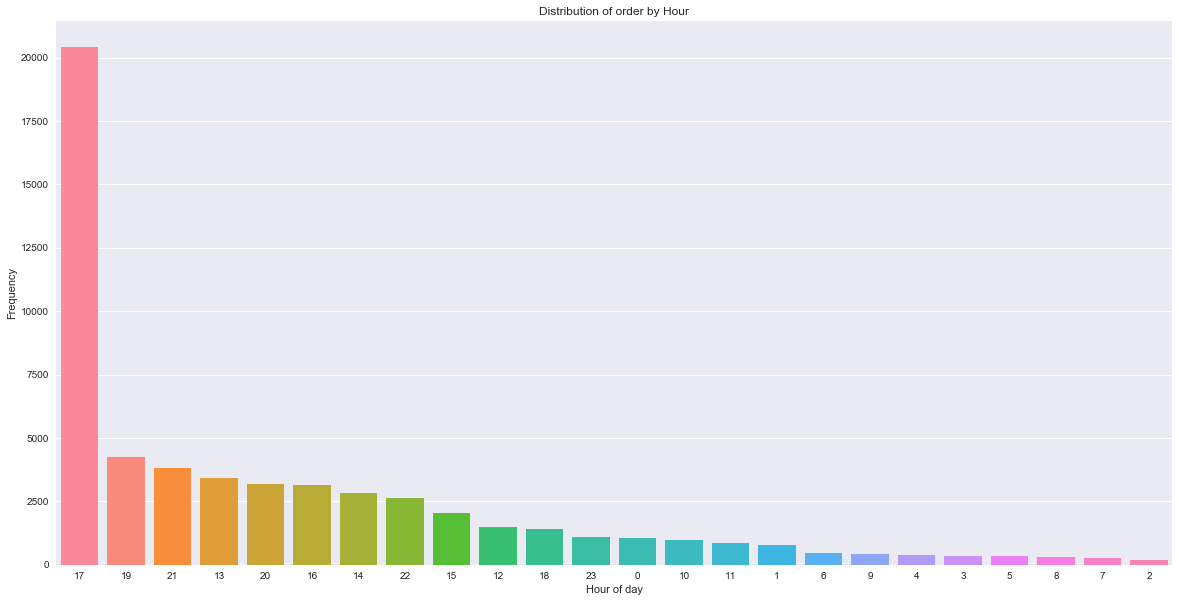

In [12]:
ops_order_hour = ops_data['Hour'].value_counts(sort=True)
plt.figure(figsize=(20,10))
graph=sns.countplot(x="Hour", saturation=1, data=ops_data, order=ops_order_hour.index)
plt.title("Distribution of order by Hour")
plt.xlabel("Hour of day")
plt.ylabel("Frequency")

The above distribution shows that most of the activity, by far, is around 5pm!

Perhaps this is a internal work system and 17:00 is when workers are clocking off the system! I would need more information about the system to make a conclusion

In [13]:
ops_data['user_id'].groupby(ops_data['op_count']).describe().unstack()

,count,unique,top,freq
op_count,,,,
1,56061,128,34b53010170f,20978
2,6,3,45683bb5c092,3
3,2,1,b367616f94b3,2
4,1,1,b8f2d77af0e5,1
6,1,1,39c072ce2e03,1
8,1,1,b8f2d77af0e5,1
9,1,1,08da5e14a8ba,1
15,2,1,b367616f94b3,2
24,10,1,b367616f94b3,10


The below function indexes the ops_data with all of the unique user_ids. It then takes the first row (first time appearing) and the last row (last time user appears) and calculates the time frame in between these two instances, in hours.

We then do an inner join with the ops_data in order to ensure the correct user_id's are matched with their duration spent on the system.

THe below code could easily be turned into a function that is more generalizable should it be required.

In [14]:
user_list = list(ops_data['user_id'].unique())
aux = []
for i_d in user_list:
    
    boolean = ops_data['user_id'] == i_d
    intermediate_dataframe = pd.DataFrame(ops_data[boolean])
    intermediate_dataframe.sort(['op_time'], inplace=True)
    first_activity = intermediate_dataframe.iloc[0][0]
    last_activity = intermediate_dataframe.iloc[-1][0]
    f = datetime.strptime(first_activity, "%Y-%m-%d %H:%M:%S")
    l = datetime.strptime(last_activity, "%Y-%m-%d %H:%M:%S")
    delta = (l-f).seconds
    delta = delta/3600
    aux.append((i_d, delta))
to_be_merged = pd.DataFrame.from_records(aux, columns =['user_id', 'Total_Time (Hrs)'])
new_user_data = pd.merge(users_data, to_be_merged, on = 'user_id')
new_user_data.sort(['Total_Time (Hrs)'], inplace=True, ascending=False)
new_user_data        

,user_id,signup_date,type,Total_Time (Hrs)
7,9030279ebd60,2017-04-06,Individual,23.983333
50,b8f2d77af0e5,2017-03-22,Enterprise,23.900000
114,9dc11291087b,2017-02-22,Enterprise,23.850000
8,2d9d9ee1ed24,2017-01-11,Individual,23.850000
97,26cc965f9485,2016-10-26,Enterprise,23.500000
71,e6ab9d1e1f33,2016-12-01,Enterprise,23.150000
88,e5962c076c68,2016-10-09,Individual,22.116667
94,b766bf538f32,2017-03-31,Individual,22.083333
67,ff44ff992d7e,2017-01-10,Enterprise,22.083333
5,cf50bff1e279,2017-03-03,Enterprise,21.933333


The above table shows you the total number of hours that each user has spent on the system with regards to all the available data we have.

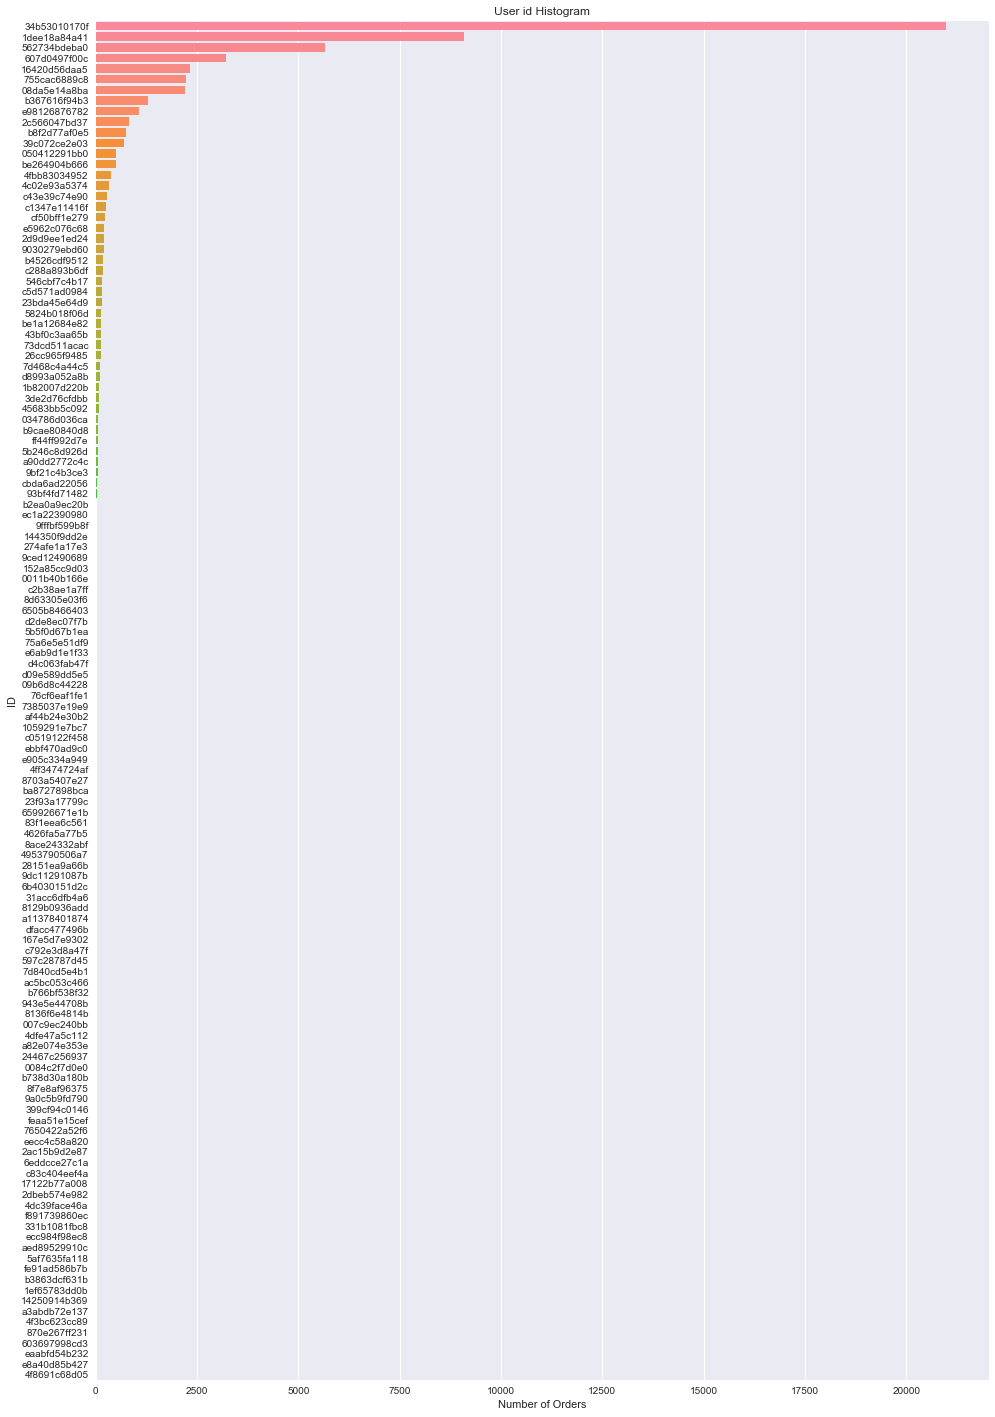

In [15]:
ops_user_hist = ops_data['user_id'].value_counts(sort=True)
plt.figure(figsize=(16,25))
graph=sns.countplot(y="user_id", saturation=1, data=ops_data, order=ops_user_hist.index)
plt.title("User id Histogram")
plt.xlabel("Number of Orders")
plt.ylabel("ID")

The above graph shows that user_id '34b53010170f' is by far the most active.

However, this visual seems to show that other users are not active. This is not true! We simply need to zoom in on our histrogram to see the other data points.

Here we can see the other users!

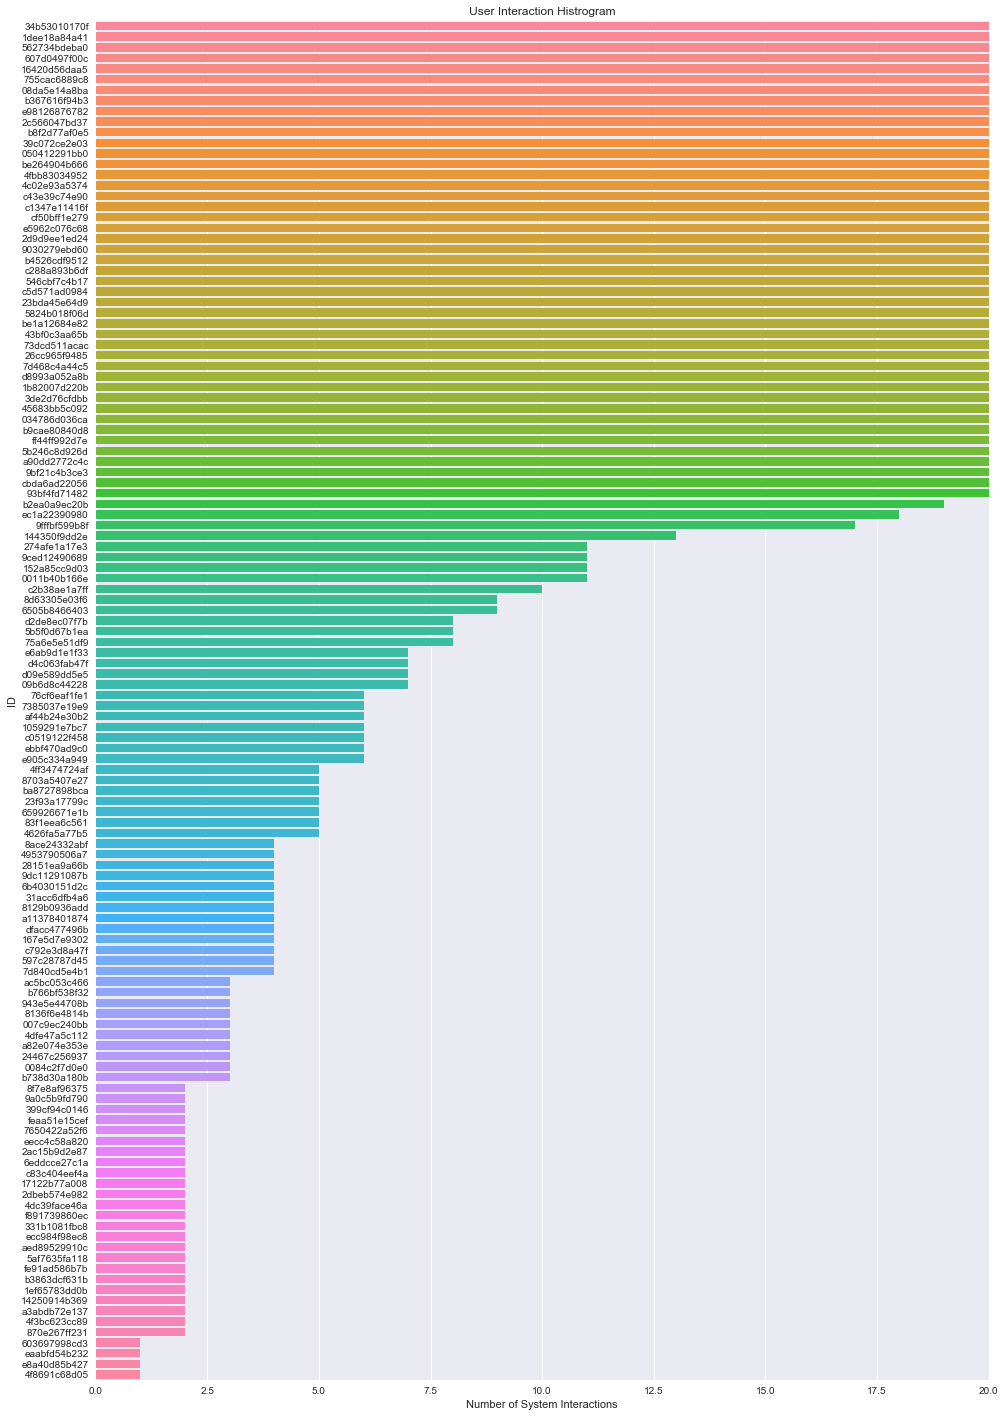

In [16]:
ops_user_hist = ops_data['user_id'].value_counts(sort=True)
plt.figure(figsize=(16,25))
graph=sns.countplot(y="user_id", saturation=1, data=ops_data, order=ops_user_hist.index)
plt.title("User Interaction Histrogram")
plt.xlabel("Number of System Interactions")
plt.xlim((0, 20))
plt.ylabel("ID")

# USERS DATABASE

Continuing on from before:

We can now describe the total distrubution of time spent on the system! Let's also quickly assess the breakdown between the types of users. 

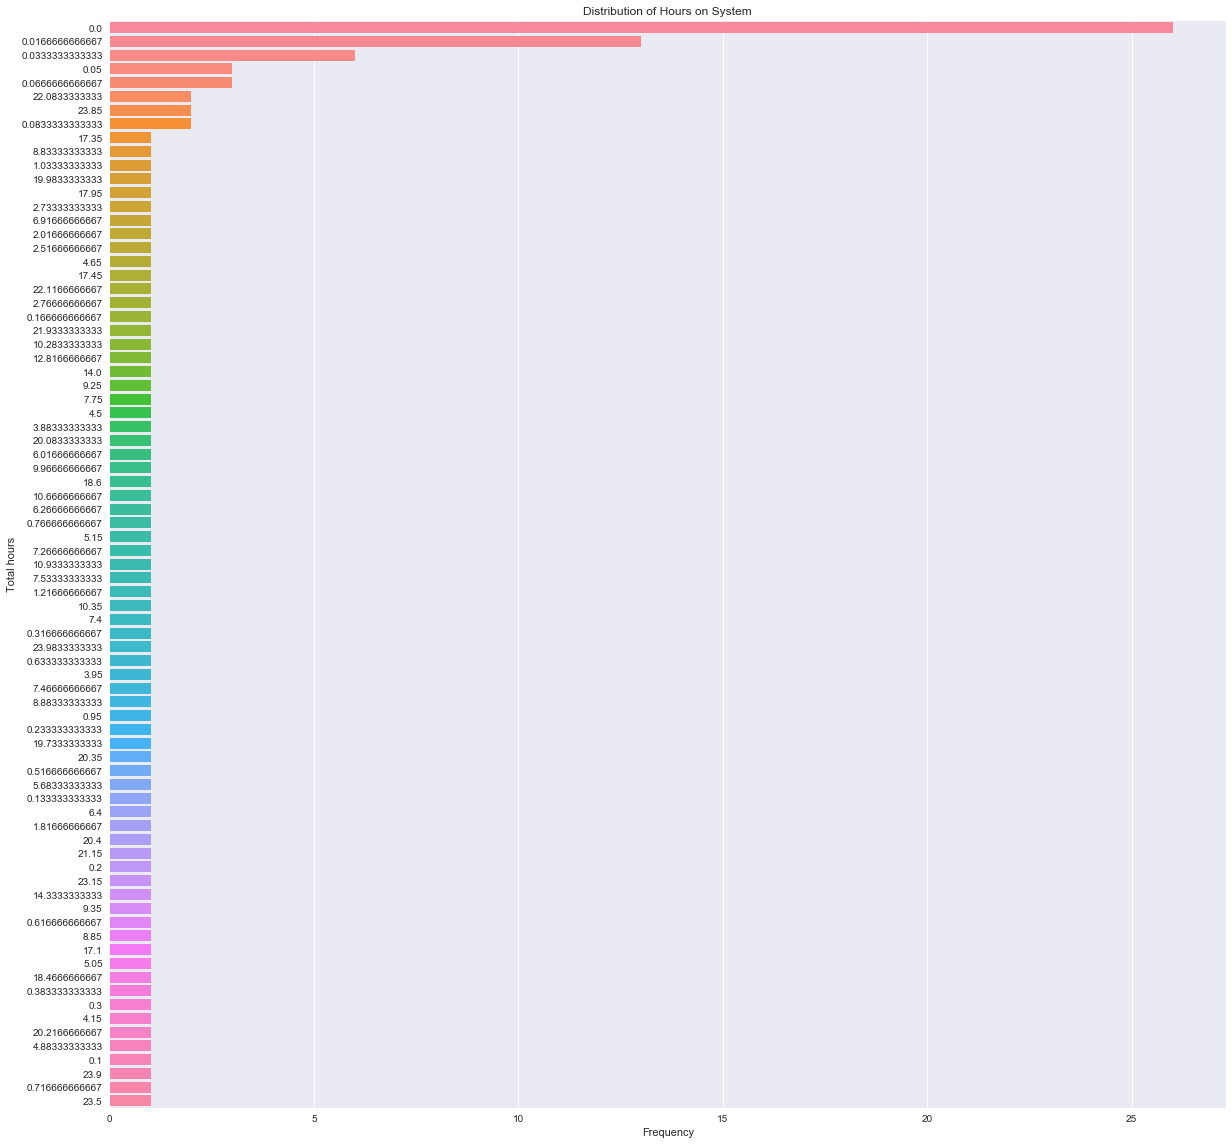

In [17]:
new_user_hours_hist = new_user_data['Total_Time (Hrs)'].value_counts(sort=True)
plt.figure(figsize=(20,20))
graph=sns.countplot(y="Total_Time (Hrs)", saturation=1, data=new_user_data, order=new_user_hours_hist.index)
plt.title("Distribution of Hours on System")
plt.xlabel("Frequency")
plt.ylabel("Total hours")

In [18]:
users_data.head(1)

,user_id,signup_date,type
0,45683bb5c092,2015-05-20,Enterprise


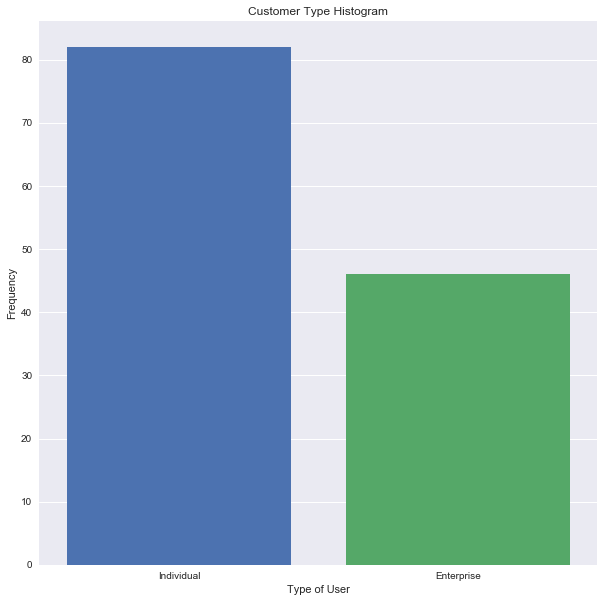

In [19]:
user_type_hist = users_data['type'].value_counts(sort=True)
plt.figure(figsize=(10,10))
graph=sns.countplot(x="type", saturation=1, data=users_data, order=user_type_hist.index)
plt.title("Customer Type Histogram")
plt.xlabel("Type of User")
plt.ylabel("Frequency")

From the above, we can quickly that we have almost 2x more individual users than we do enterprise users.

As states before, the distibution of activity is very valuable information - if given more time, I would try to create a system that would automate email's to be sent to users depending on their site activity - thus, those with a high number of hours obtaining certain discount vouchers/special offers etc.

Another, idea would be to implement a simple Machine Learning algorithm, say a simple Logisitic Regression or Random Forest that would assess a user's site actvity (potential features = type of activity, op_count, hours spent, timeframe of visit) and suggest whether a user should be classified as an individual or enterprise user. This could serve to better target potential customers into the enterprise level of the system.

Naturally, in order for this to be implemented, I would need a large starting dataset of user's with their corresponding features in order to train and test my model in addition to running various cross validation sets in order to ensure accuracy. The amount of data to decently train an ML algo is around the 10K mark.

I would also like to know more about the system/service itself - this lack of context makes it difficult to make any cautious/educated inference. With more data, I could also run various statistical tests/regressions/ARIMA and try to outline 'statistically significant' trends.

I hope you enjoyed my quick analysis - I do apologise for not sending something immeadiately. It's midterm examination season at UChicago so I had to wait until I had a little free time.

Github Repo: https://github.com/igabr

Thank you for your patience and consideration,

Cheers,

Ibrahim